In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os

import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  
BS=1

In [ ]:
cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/My\ Drive/Final_Dataset_mine_full.zip

In [ ]:
#datagenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator


apply_data_augmentation = True

# Create training ImageDataGenerator object

if apply_data_augmentation:
  img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
  
  mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')  
else:
    img_data_gen = ImageDataGenerator()
    mask_data_gen = ImageDataGenerator()

test_data_gen=ImageDataGenerator()    

In [ ]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #254 instead of 216
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

  """
    CustomDataset inheriting from tf.keras.utils.Sequence.

    3 main methods:
      - __init__: save dataset params like directory, filenames..
      - __len__: return the total number of samples in the dataset
      - __getitem__: return a sample from the dataset

    Note: 
      - the custom dataset return a single sample from the dataset. Then, we use 
        a tf.data.Dataset object to group samples into batches.
      - in this case we have a different structure of the dataset in memory. 
        We have all the images in the same folder and the training and validation splits
        are defined in text files.

  """

  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[256, 256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):
    # Read Image
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask_from_rgb = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
    mask = Image.fromarray(mask_from_rgb)

    # Resize image and mask
    img = img.resize(self.out_shape)
    mask_arr = mask.resize(self.out_shape, resample=Image.NEAREST)
    
    img_arr = np.array(img)
    mask_arr = np.array(mask_arr)
    

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        # Perform data augmentation
        # We can get a random transformation from the ImageDataGenerator using get_random_transform
        # and we can apply it to the image using apply_transform
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        # ImageDataGenerator use bilinear interpolation for augmenting the images.
        # Thus, when applied to the masks it will output 'interpolated classes', which
        # is an unwanted behaviour. As a trick, we can transform each class mask 
        # separately and then we can cast to integer values (as in the binary segmentation notebook).
        # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            # from [0, 1] to {0, 1}
            curr_class_arr = np.uint8(curr_class_arr)
            # recover original class
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 1536
img_w = 2048

dataset = CustomDataset('/content/Final_Dataset_mine_full/Final_Dataset_mine/Test_Dev', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        out_shape=(img_w,img_h)) ##### first height
dataset_valid = CustomDataset('/content/Final_Dataset_mine_full/Final_Dataset_mine/Test_Dev', 'validation', 
                              out_shape=(img_w,img_h)) ###first height then width ?


In [ ]:
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))

train_dataset = train_dataset.batch(BS)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(BS)

valid_dataset = valid_dataset.repeat()


In [ ]:
# Let's test data generator
import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0. 1. 2.]


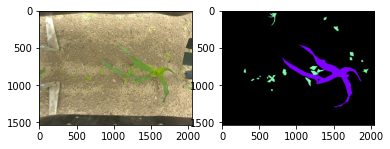

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   #First element
augmented_img = augmented_img  # denormalize


target = np.array(target[0, ..., 0])   # First element (squeezing channel dimension)

print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

In [ ]:
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
for layer in vgg.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536, 2048, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1536, 2048, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1536, 2048, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 768, 1024, 64)     0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 768, 1024, 128)    73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 768, 1024, 128)    147584    
______________________________________________________________

In [ ]:
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    # -------
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    # ----------------
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residualfoo

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model



In [ ]:
# Build model
img_size=(img_h,img_w)
num_classes=3
model = get_model(img_size, num_classes)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 768, 1024, 32 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 768, 1024, 32 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 768, 1024, 32 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#model = create_model(depth=5, 
                 #    start_f=8, 
                   #  num_classes=3)

# Visualize created model as a table
#model.summary()

# Visualize initialized weights
# model.weights

In [ ]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
# learning rate
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Here we define the intersection over union for each class in the batch.
# Then we compute the final iou as the mean over classes
def meanIoU(y_true, y_pred):
    # get predicted class from softmax
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(1,3): # exclude the background class 0
      # Get prediction and target related to only a single class (i)
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics
#------------------
metrics = ['accuracy', meanIoU]
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import os
from datetime import datetime

cwd = os.getcwd()

exps_dir = os.path.join(cwd, 'drive/My Drive/Keras4/', 'multiclass_segmentation_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# How to visualize Tensorboard
# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)

       
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
early_stop = False
if early_stop:
    es_callback = tf.keras.callback.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights = True )
    callbacks.append(es_callback)

In [ ]:
model.fit(x=train_dataset,
          epochs=20,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)//BS,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid), 
          callbacks=callbacks)

Epoch 1/20
186/186 [==============================] - 437s 2s/step - loss: 0.4859 - accuracy: 0.9031 - meanIoU: 0.2904 - val_loss: 0.9646 - val_accuracy: 0.9092 - val_meanIoU: 1.9585e-12
Epoch 2/20
186/186 [==============================] - 426s 2s/step - loss: 0.1472 - accuracy: 0.9543 - meanIoU: 0.3812 - val_loss: 0.4337 - val_accuracy: 0.9092 - val_meanIoU: 1.0180e-04
Epoch 3/20
186/186 [==============================] - 427s 2s/step - loss: 0.1240 - accuracy: 0.9578 - meanIoU: 0.4081 - val_loss: 0.1022 - val_accuracy: 0.9716 - val_meanIoU: 0.3915
Epoch 4/20
186/186 [==============================] - 427s 2s/step - loss: 0.1118 - accuracy: 0.9600 - meanIoU: 0.4276 - val_loss: 0.0933 - val_accuracy: 0.9699 - val_meanIoU: 0.4736
Epoch 5/20
186/186 [==============================] - 426s 2s/step - loss: 0.1046 - accuracy: 0.9616 - meanIoU: 0.4432 - val_loss: 0.0935 - val_accuracy: 0.9669 - val_meanIoU: 0.4567
Epoch 6/20
186/186 [==============================] - 427s 2s/step - loss: 0.

In [ ]:
import time
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
from os import listdir

%matplotlib inline

#iterator = iter(valid_dataset)

In [ ]:

def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
import json
import cv2

submission_dict = {}
test_dir='/content/Final_Dataset_mine_full/Final_Dataset_mine/Test_Final'
teams= ['Bipbip','Pead','Roseau','Weedelec']
plants=['Haricot','Mais']

for team in teams:
  if (team == 'Bipbip'):
    shape = (2048,1536) #(W,H)
  if (team == 'Pead'):
    shape = (3280,2464)
  if (team == 'Roseau'):
    shape = (1227,819)
  if (team == 'Weedelec'):
    shape = (5184,3456)
  for plant in plants:
    path=test_dir+'/'+team+'/'+plant+'/Images'
    for image in os.listdir(path):
      img = Image.open(os.path.join(path, image))
      imgsize=img.size
      print(imgsize)
      
      #img=img.resize(shape) ### not really needed
      img=np.array(img)
      
      if (team =='Bipbip'):
        out_sigmoid = model.predict(x=tf.expand_dims(img, 0))
        predicted_class = tf.argmax(out_sigmoid, -1)
        predicted_class = predicted_class[0, ...]
        predicted_class=np.asarray(predicted_class)
      else :
        predicted_class = np.zeros([imgsize[0], imgsize[1], 3])
        predicted_class = np.asarray(predicted_class)
      
      if (team == 'Roseau'):
        img_name = image.replace('.png', '')
      else:
        img_name = image.replace('.jpg', '')
      print(img_name) 

      
      submission_dict[img_name] = {}
      submission_dict[img_name]['shape'] = predicted_class.shape
      submission_dict[img_name]['team'] = team
      submission_dict[img_name]['crop'] = plant
      submission_dict[img_name]['segmentation'] = {}

      rle_encoded_crop = rle_encode(predicted_class == 1)
      
      rle_encoded_weed = rle_encode(predicted_class == 2)

      submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
      submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed


In [ ]:
from datetime import datetime

exps_dir = os.path.join(cwd, 'drive/My Drive/predictions')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)


dir=exps_dir+'/submission'+'_'+datetime.now().strftime('%b%d_%H-%M-%S')+'.json'
with open(dir, 'w') as f:
  json.dump(submission_dict, f)

Visualize prediction in validation set example

In [ ]:
##### TEST PREDICTION ON VALID DATASET
iterator=iter(valid_dataset)


image,target = next(iterator)
print(image.dtype)
image = image[0]
target = target[0, ..., 0]

print(image.shape)
print(target.shape)

out_sigmoid = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_sigmoid, -1)

out_sigmoid.shape

predicted_class = predicted_class[0, ...]


# Assign colors (just for visualization)
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()

target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 3):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)